In [1]:
import torch
from PIL import Image, ImageOps
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from transformers import SamModel, SamProcessor
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from sam_utils import (
    show_masks_on_image, 
    show_boxes_on_image, 
    resize_pil_image,
    show_points_on_image
    )

c:\Users\Maods\Documents\Development\Mestrado\project-tree\owl-vit\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
owl_processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
owl_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

c:\Users\Maods\Documents\Development\Mestrado\project-tree\owl-vit\.env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tensor([[924., 693.]])

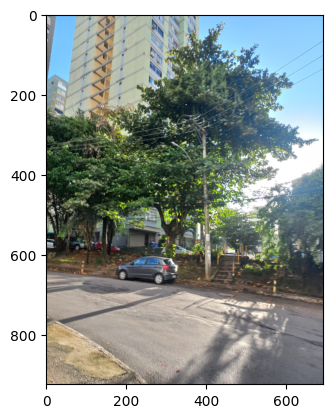

In [34]:
image_path = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Camera Celular\20240531_070713.jpg'
# image_path = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Camera Celular\20240531_070722.jpg'
# image_path = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Camera Celular\20240531_070834.jpg'
# image_path = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240601 Redmi 10 Prime\IMG_20240601_102833.jpg'
# image_path = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Open Camera\IMG_20240531_075143.jpg'


# image_path = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\owl-vit\IMG_8293.JPEG'

PIL.Image.MAX_IMAGE_PIXELS = 933120000
raw_image = Image.open(image_path).convert("RGB")
raw_image = ImageOps.exif_transpose(raw_image)
raw_image = resize_pil_image(raw_image, ratio=0.2)
plt.imshow(raw_image)

target_sizes = torch.Tensor([raw_image.size[::-1]])
target_sizes

In [70]:
texts = [["an single tree"]]
inputs = owl_processor(text=texts, images=raw_image, return_tensors="pt")
outputs = owl_model(**inputs)

In [71]:
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = owl_processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
boxes_post_process = []
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    boxes_post_process.append(box)
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected an single tree with confidence 0.114 at location [219.17, 16.39, 636.21, 651.11]


In [72]:
def find_center(box):
    x_c = round(((box[2] - box[0])/2)+ box[0])
    y_c  = round(((box[3] - box[1])/2)+ box[1])
    return [x_c, y_c]

centers = []
for box in boxes_post_process:
    center = find_center(box)
    centers.append(center)
    print(f"Center of the detected {text} is at {center}")
    

Center of the detected ['an single tree'] is at [428, 334]


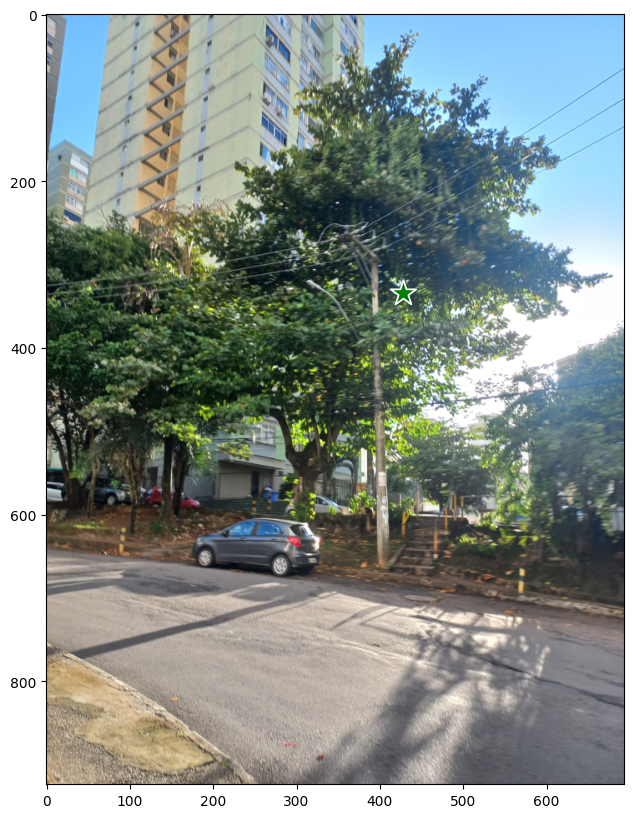

In [73]:
input_points = [centers]
show_points_on_image(raw_image, input_points[0])

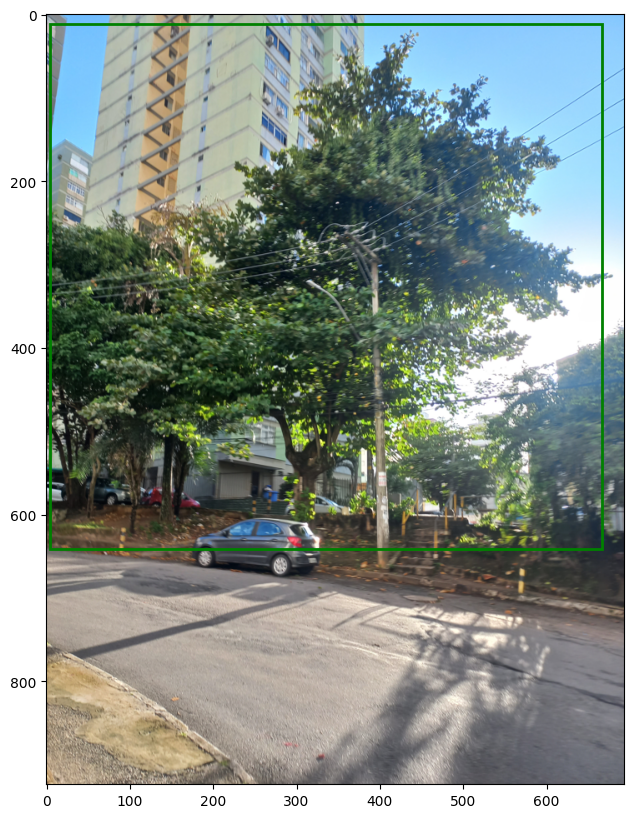

In [8]:
show_boxes_on_image(raw_image, [box]) 

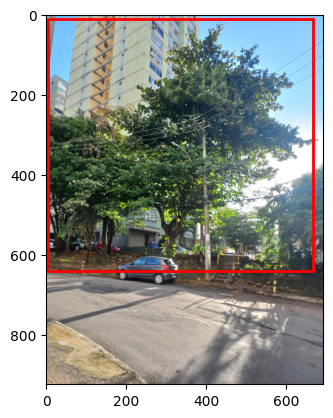

In [9]:

img = raw_image.copy()


fig, ax = plt.subplots()
ax.imshow(img)

# Iterandoresults sobre os boxes e plotando cada um
for box in results[0]["boxes"].cpu().detach().numpy():
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    
    # Adicionando o bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # break

# Exibindo a imagem
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [11]:
inputs = sam_processor(raw_image, return_tensors="pt").to(device)
image_embeddings = sam_model.get_image_embeddings(inputs["pixel_values"])

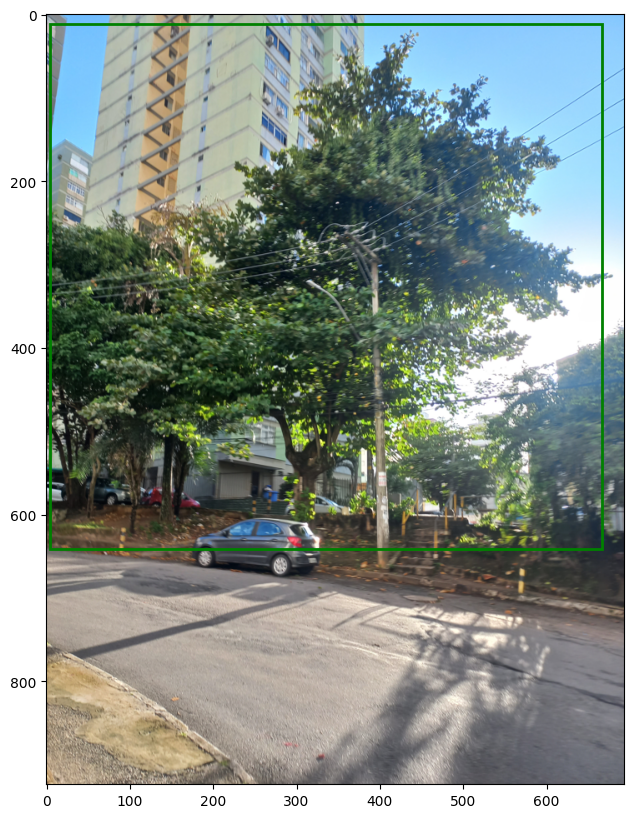

In [12]:
# input_points = [[[x_min, y_min, x_max, y_max]]]
input_boxes = [[[x_min, y_min, x_max, y_max]]]

show_boxes_on_image(raw_image, input_boxes[0]) 

In [13]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

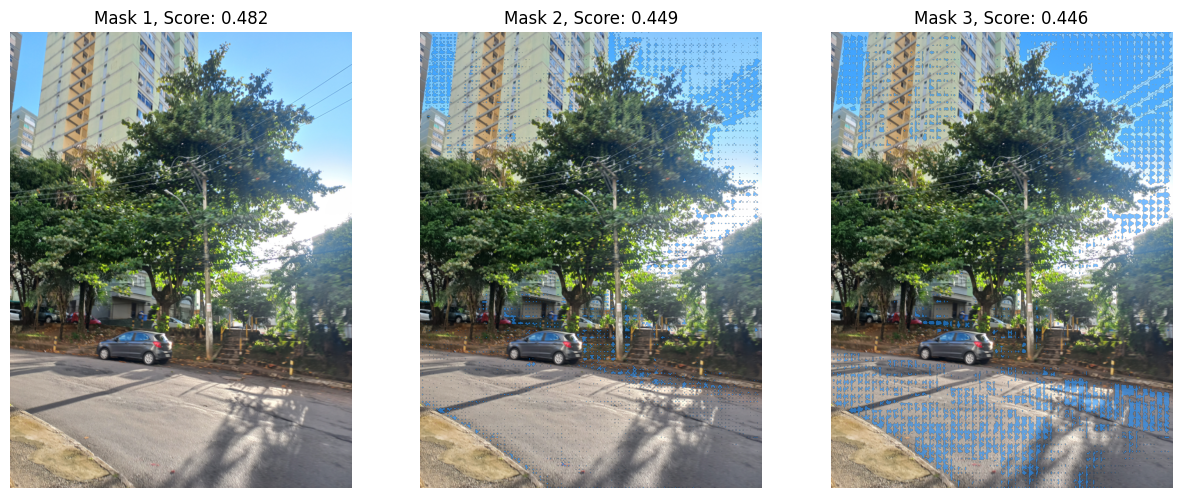

In [14]:
show_masks_on_image(raw_image, masks[0], scores)

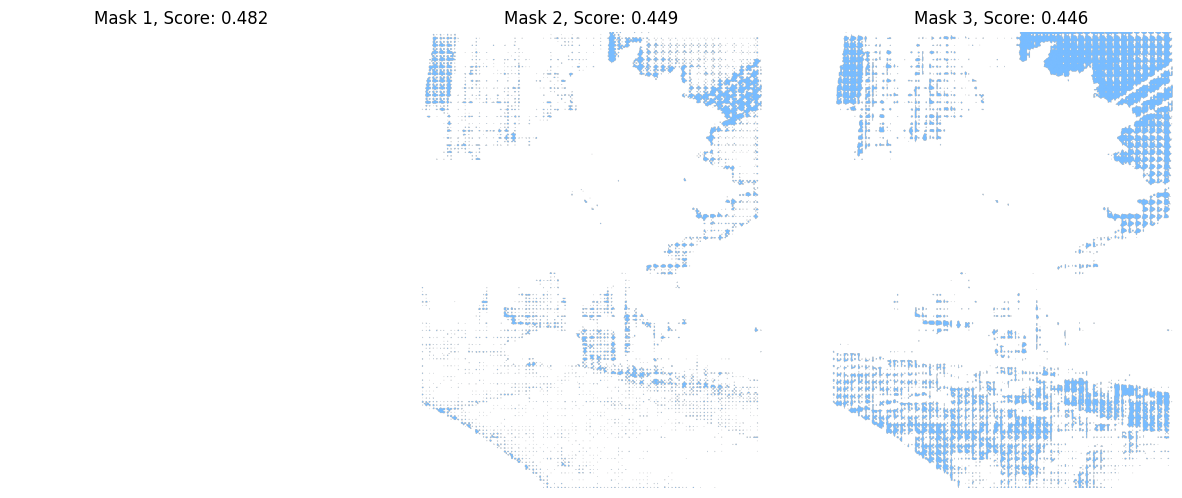

In [15]:
show_masks_on_image(raw_image, masks[0], scores, True)

In [16]:
inputs = sam_processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [17]:
scores.shape

torch.Size([1, 1, 3])

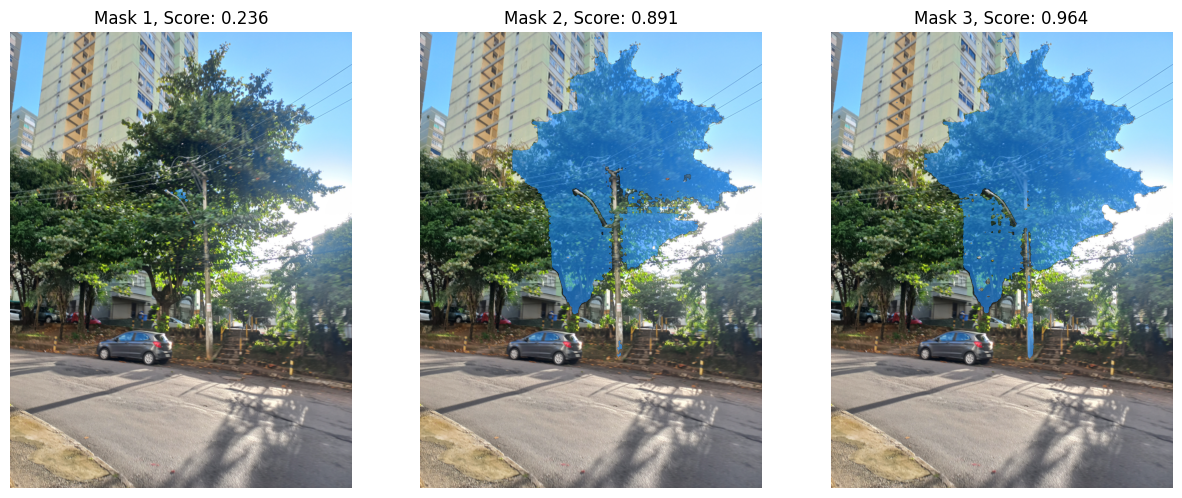

In [18]:
show_masks_on_image(raw_image, masks[0], scores)

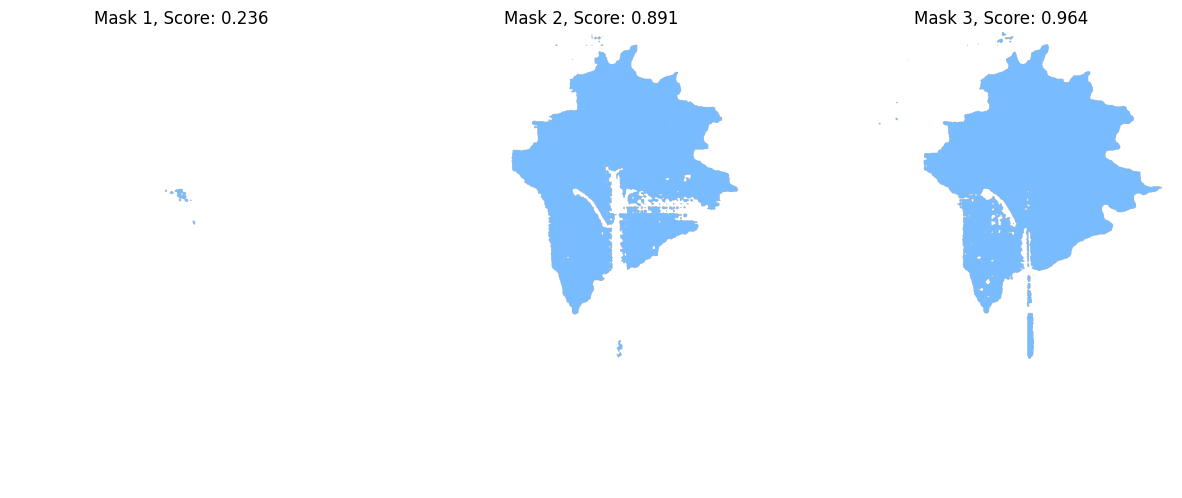

In [19]:
show_masks_on_image(raw_image, masks[0], scores, True)